In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )
source("script/colors.R"    )


In [3]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(edgeR))


In [4]:
acc <- read.table("/projects/CARDIPS/analysis/scRNAseq_validation/heart/summary.gene_tpm.cell_tissue.txt", header=T)
#acc <- acc %>% filter(tissue1=="ipsc_cvpc" & tissue2=="heart" & cell_type=="cardiac_muscle") %>% filter(group!="Other")

In [5]:
load("/projects/CARDIPS/analysis/scRNAseq_validation/heart/Robj/obj.LV.scaled.mapped.R")
obj.adult <- obj
dim(obj.adult)
rm(obj)

[1] 29357 33050

In [6]:
load("/projects/CARDIPS/analysis/scRNAseq_validation/heart/Robj/obj.cvpc.R")
obj.cvpc <- obj
dim(obj.cvpc)
rm(obj)

[1] 25971 32026

In [7]:
count.adult <- GetAssayData(obj.adult, slot="counts")[,which(obj.adult@meta.data$ident.cell=="cardiac_muscle")]
count.cvpc <- GetAssayData(obj.adult, slot="counts")[,which(obj.cvpc@meta.data$ident.cell=="CM")]

In [8]:
dim(count.adult)
dim(count.cvpc)

[1] 29357 20460

[1] 29357 21001

In [9]:
x <- merge(data.frame(row.names=rownames(count.adult),
                      count.adult=apply(count.adult, 1, sum),
                      f.adult=apply(count.adult, 1, function(x) length(which(x>0))/length(x))),
           data.frame(row.names=rownames(count.cvpc),
                      count.cvpc=apply(count.cvpc, 1, sum),
                      f.cvpc=apply(count.cvpc, 1, function(x) length(which(x>0))/length(x))),
           by="row.names", all=F)

In [10]:
rownames(x) <- x[,1]
x <- x[,2:ncol(x)]
dim(x)

[1] 29357     4

In [11]:
f <- calcNormFactors(x[,c("count.adult","count.cvpc")])

In [12]:
f

count.adult  count.cvpc 
   0.940681    1.063060

In [13]:
x$normed.adult <- x$count.adult/f["count.adult"]
x$normed.cvpc <- x$count.cvpc/f["count.cvpc"]

In [14]:
x$log2FC <- log2(x$normed.adult / x$normed.cvpc)

In [15]:
str(x)

'data.frame':	29357 obs. of  7 variables:
 $ count.adult : num  1 8 4 5 751 153 9 2 256 325 ...
 $ f.adult     : num  4.89e-05 3.91e-04 1.96e-04 2.44e-04 3.51e-02 ...
 $ count.cvpc  : num  0 16 12 4 1016 ...
 $ f.cvpc      : num  0 0.000762 0.000571 0.00019 0.045331 ...
 $ normed.adult: num  1.06 8.5 4.25 5.32 798.36 ...
 $ normed.cvpc : num  0 15.05 11.29 3.76 955.73 ...
 $ log2FC      : num  Inf -0.824 -1.409 0.498 -0.26 ...


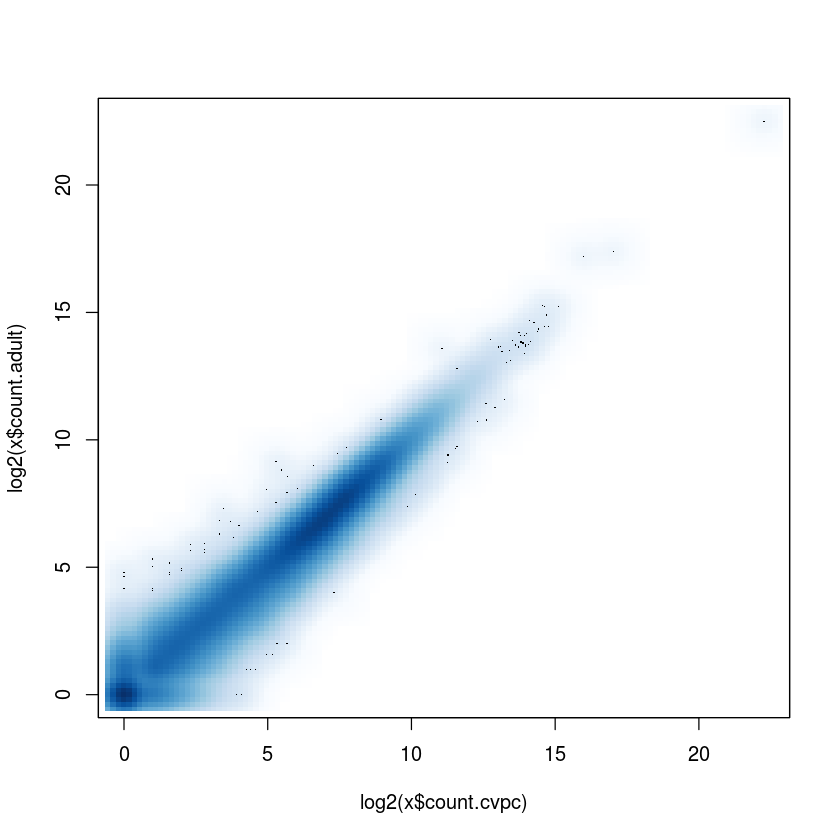

In [16]:
smoothScatter(log2(x$count.cvpc), log2(x$count.adult))

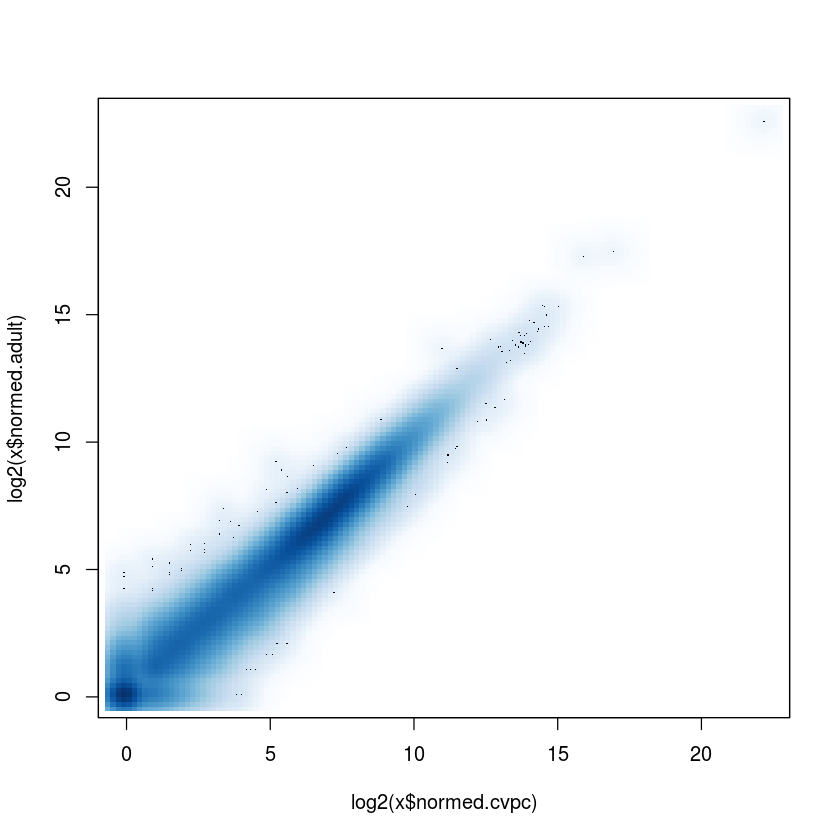

In [17]:
smoothScatter(log2(x$normed.cvpc), log2(x$normed.adult))

In [18]:
dim(x)
length(unique(acc$gene_name))
dim(acc %>% filter(tissue1=="ipsc_cvpc" & tissue2=="heart" & cell_type=="cardiac_muscle"))
length(unique(acc %>% filter(tissue1=="ipsc_cvpc" & tissue2=="heart" & cell_type=="cardiac_muscle") %>% pull(gene_name)))
length(which(rownames(x) %in% acc$gene_name))

[1] 29357     7

[1] 20357

[1] 20393    10

[1] 20357

[1] 18534

In [21]:
t <- merge(x, acc %>% filter(tissue1=="ipsc_cvpc" & tissue2=="heart" & cell_type=="cardiac_muscle"),
          by.x="row.names", by.y="gene_name", all=F)

fwrite(t, "pipeline/4.1.differential_expression/scrna_validation.stage.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [20]:
str(t)

'data.frame':	18545 obs. of  17 variables:
 $ Row.names    : 'AsIs' chr  "A1BG" "A1BG-AS1" "A2M" "A2M-AS1" ...
 $ count.adult  : num  8 4 751 153 256 ...
 $ f.adult      : num  0.000391 0.000196 0.035142 0.007429 0.012219 ...
 $ count.cvpc   : num  16 12 1016 119 276 ...
 $ f.cvpc       : num  0.000762 0.000571 0.045331 0.005666 0.012761 ...
 $ normed.adult : num  8.5 4.25 798.36 162.65 272.14 ...
 $ normed.cvpc  : num  15.1 11.3 955.7 111.9 259.6 ...
 $ log2FC       : num  -0.8236 -1.4085 -0.2596 0.539 0.0679 ...
 $ transcript_id: chr  "ENSG00000121410.12_6" "ENSG00000268895.6_7" "ENSG00000175899.15_6" "ENSG00000245105.4_7" ...
 $ cell_type    : chr  "cardiac_muscle" "cardiac_muscle" "cardiac_muscle" "cardiac_muscle" ...
 $ tissue1      : chr  "ipsc_cvpc" "ipsc_cvpc" "ipsc_cvpc" "ipsc_cvpc" ...
 $ tissue2      : chr  "heart" "heart" "heart" "heart" ...
 $ tiss1_beta   : num  -1.516 -0.433 0.557 1.157 3.096 ...
 $ tiss1_qval   : num  0.65298 1 1 1 0.00164 ...
 $ tiss2_beta   : num  -1.

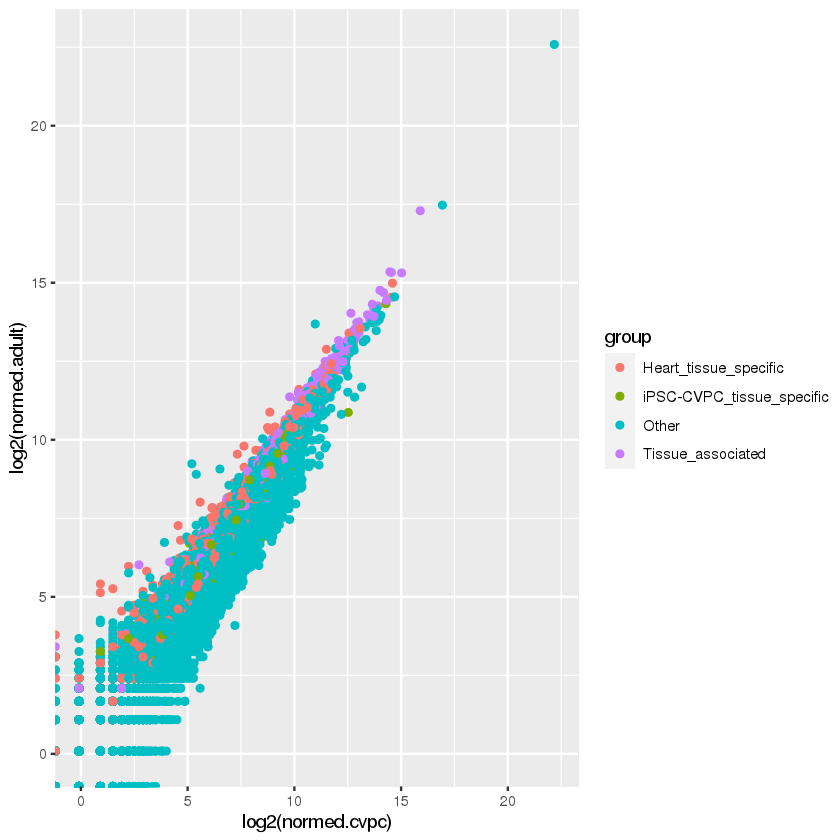

In [96]:
ggplot(t, aes(log2(normed.cvpc), log2(normed.adult))) + geom_point(aes(col=group))

Warning message:
“Removed 913 rows containing non-finite values (stat_boxplot).”


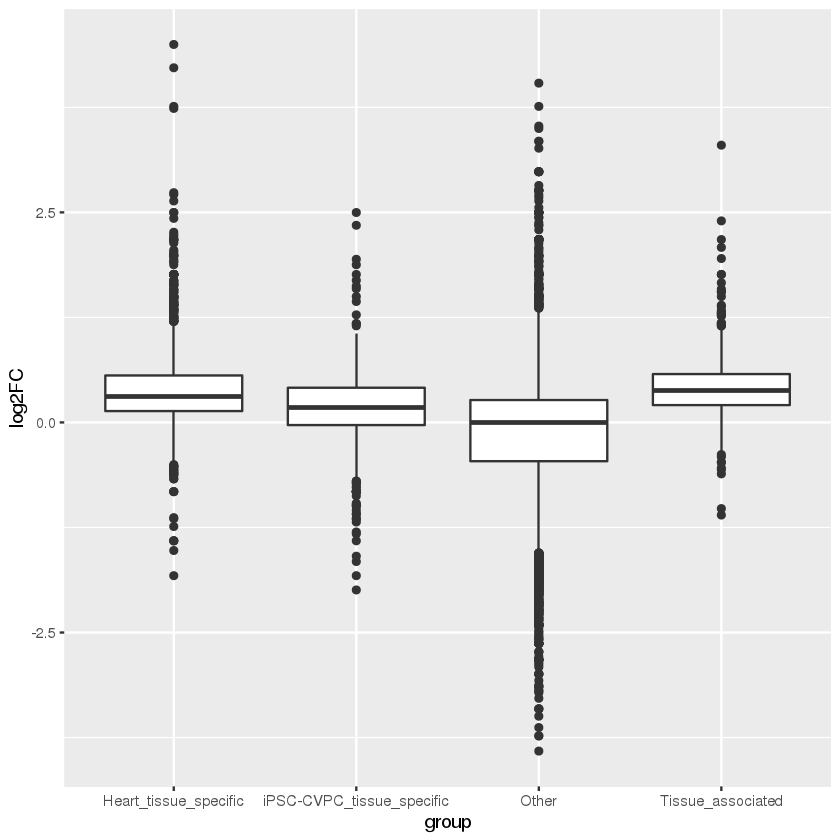

In [97]:
ggplot(t, aes(group, log2FC)) + geom_boxplot()

In [100]:
cor.test(t$tiss1_beta, t$normed.cvpc)
cor.test(t$tiss2_beta, t$normed.cvpc)


	Pearson's product-moment correlation

data:  t$tiss1_beta and t$normed.cvpc
t = 0.75899, df = 18543, p-value = 0.4479
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.008819694  0.019964649
sample estimates:
        cor 
0.005573632 



	Pearson's product-moment correlation

data:  t$tiss2_beta and t$normed.cvpc
t = -0.4415, df = 18543, p-value = 0.6589
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.01763401  0.01115092
sample estimates:
         cor 
-0.003242217 


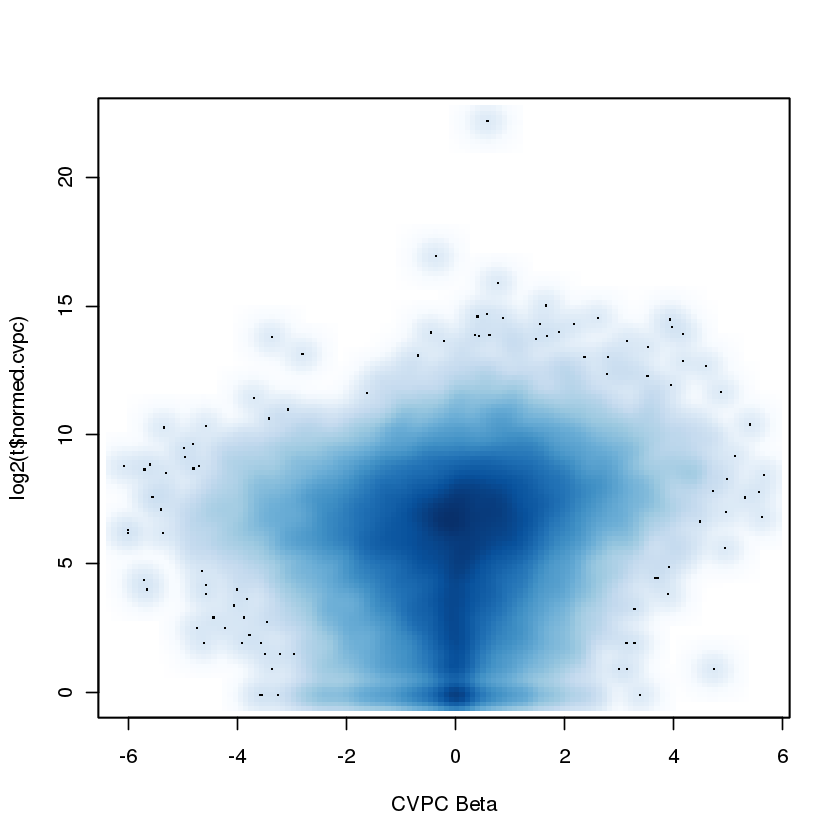

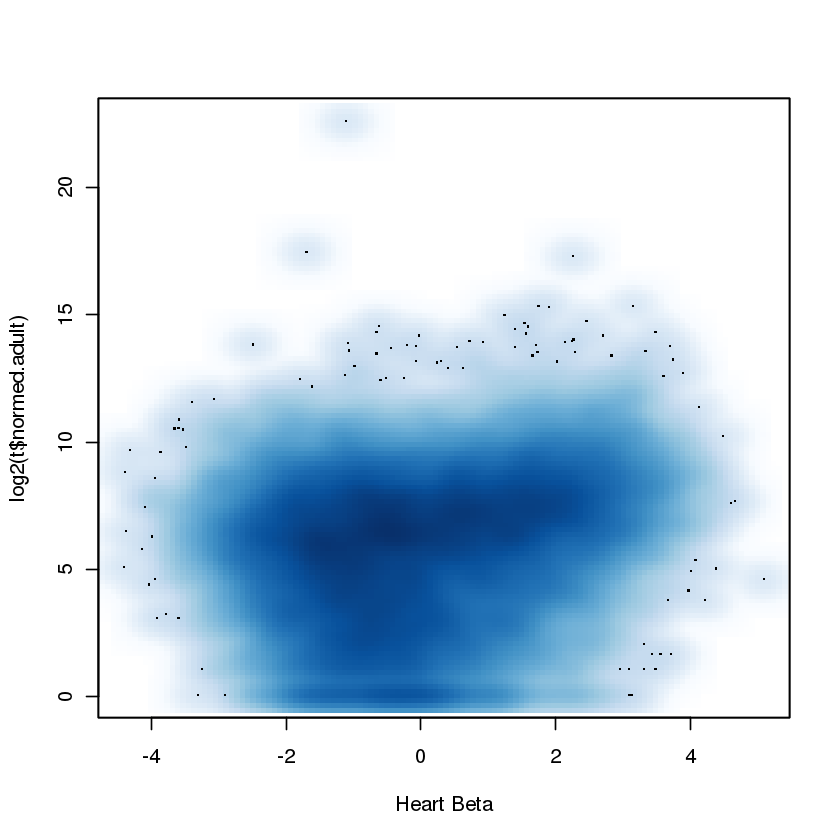

In [65]:
smoothScatter(t$tiss1_beta, log2(t$normed.cvpc), xlab="CVPC Beta")
smoothScatter(t$tiss2_beta, log2(t$normed.adult), xlab="Heart Beta")

In [102]:
cor.test(t[!is.infinite(t$log2FC),"tiss1_beta"], t[!is.infinite(t$log2FC),"log2FC"])
cor.test(t[!is.infinite(t$log2FC),"tiss2_beta"], t[!is.infinite(t$log2FC),"log2FC"])


	Pearson's product-moment correlation

data:  t[!is.infinite(t$log2FC), "tiss1_beta"] and t[!is.infinite(t$log2FC), "log2FC"]
t = 40.708, df = 17630, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2795722 0.3065573
sample estimates:
      cor 
0.2931232 



	Pearson's product-moment correlation

data:  t[!is.infinite(t$log2FC), "tiss2_beta"] and t[!is.infinite(t$log2FC), "log2FC"]
t = 65.374, df = 17630, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4297598 0.4535219
sample estimates:
      cor 
0.4417183 


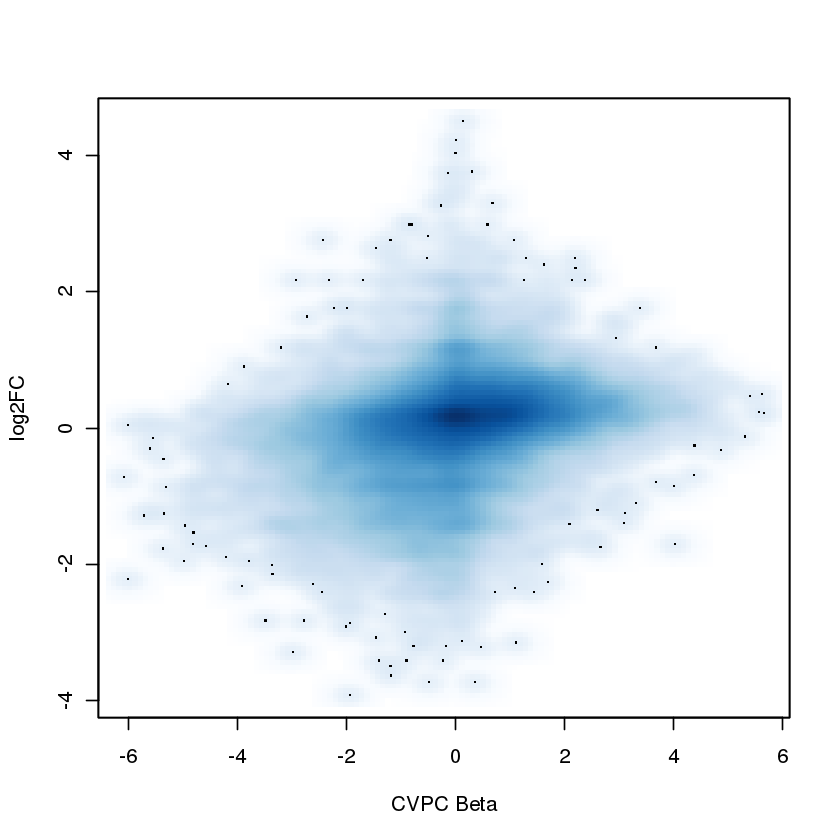

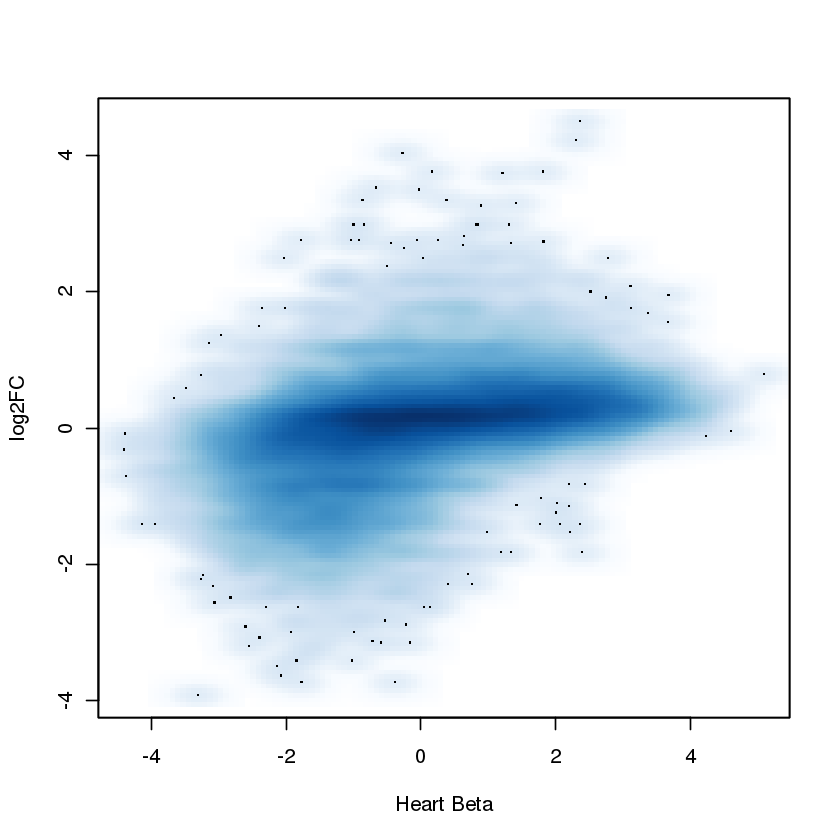

In [66]:
smoothScatter(t$tiss1_beta, t$log2FC, xlab="CVPC Beta", ylab="log2FC")
smoothScatter(t$tiss2_beta, t$log2FC, xlab="Heart Beta", ylab="log2FC")

In [126]:
t.1 <- t[!is.infinite(t$log2FC),]

In [127]:
dim(t)
dim(t.1)

[1] 18545    17

[1] 17794    17

In [129]:
cor.test(t.1$tiss2_beta - t.1$tiss1_beta, t.1$log2FC)


	Pearson's product-moment correlation

data:  t.1$tiss2_beta - t.1$tiss1_beta and t.1$log2FC
t = 27.413, df = 17630, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1879922 0.2163067
sample estimates:
      cor 
0.2021917 


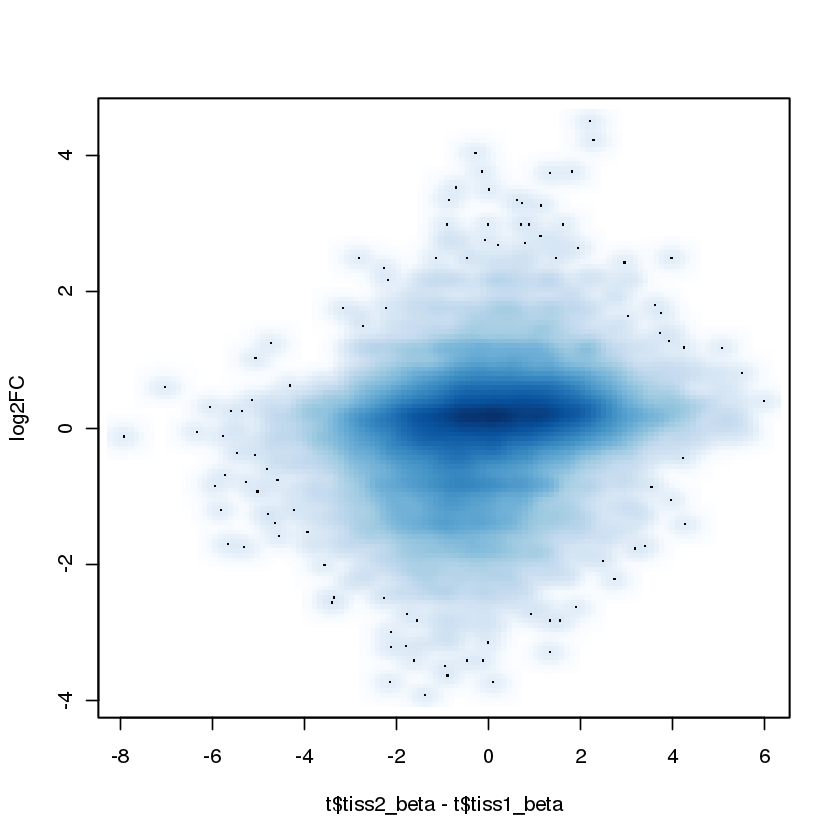

In [130]:
smoothScatter(t$tiss2_beta - t$tiss1_beta, t$log2FC, ylab="log2FC")

Warning message:
“Removed 10 rows containing missing values (geom_point).”


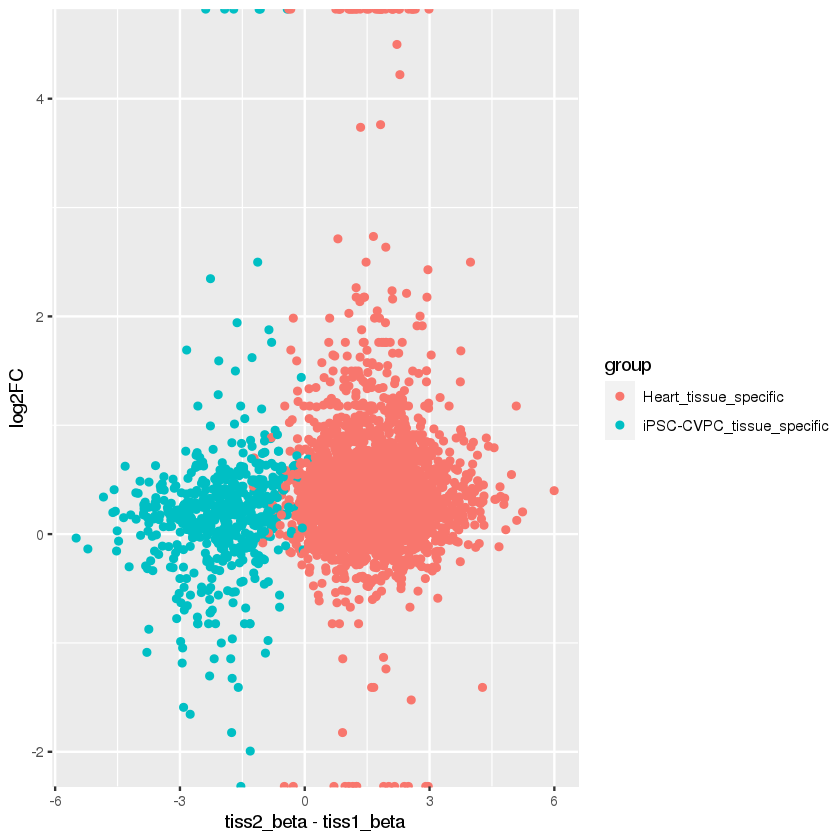

In [132]:
ggplot(t %>% filter(group=="Heart_tissue_specific" | group=="iPSC-CVPC_tissue_specific"), aes(tiss2_beta - tiss1_beta, log2FC)) + geom_point(aes(col=group))

In [135]:
t.test(t.1 %>% filter(group=="Heart_tissue_specific") %>% pull(log2FC),
      t.1 %>% filter(group=="iPSC-CVPC_tissue_specific") %>% pull(log2FC))


	Welch Two Sample t-test

data:  t.1 %>% filter(group == "Heart_tissue_specific") %>% pull(log2FC) and t.1 %>% filter(group == "iPSC-CVPC_tissue_specific") %>% pull(log2FC)
t = 9.3631, df = 720.62, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1691601 0.2589203
sample estimates:
mean of x mean of y 
0.3720441 0.1580039 


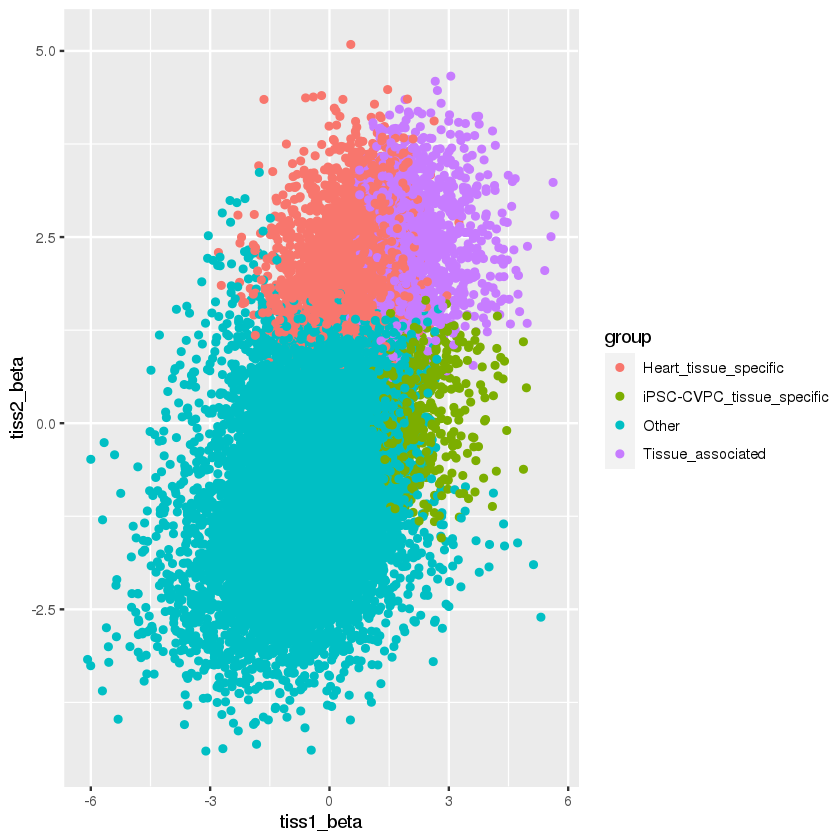

In [111]:
ggplot(t, aes(tiss1_beta, tiss2_beta)) + geom_point(aes(col=group))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 68 rows containing non-finite values (stat_bin).”


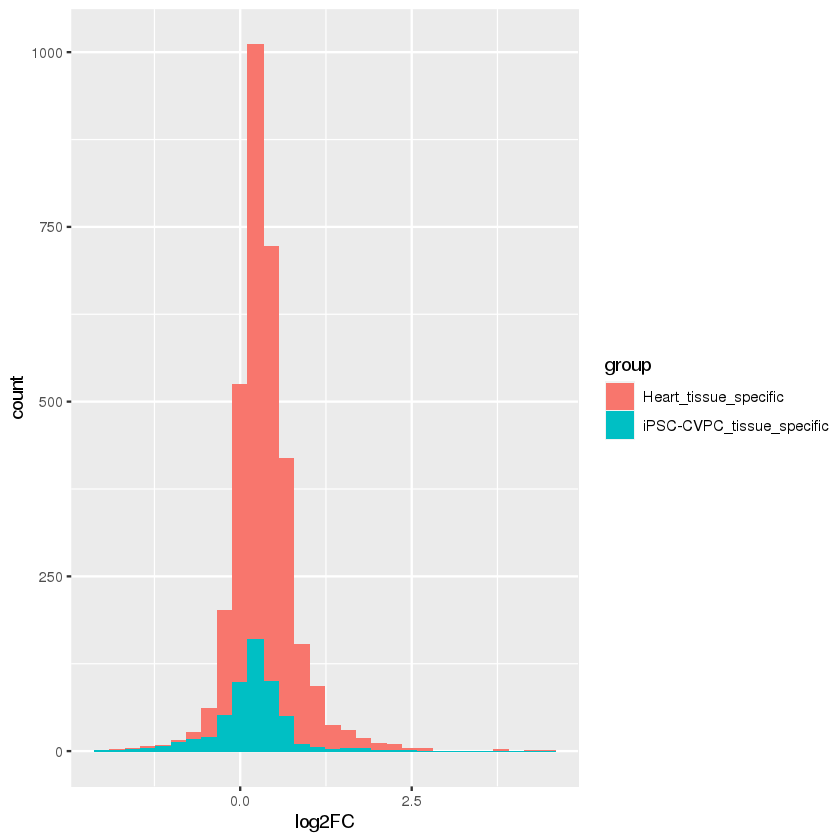

In [117]:
ggplot(t %>% filter(group=="Heart_tissue_specific" | group=="iPSC-CVPC_tissue_specific"), aes(log2FC)) + geom_histogram(aes(fill=group))